# Sampling from the Variational Autoencoder
In the exercise on autoencoders you plotted the hidden units of the autoencoer using TSNE. The autoencoders from the exercise (vanilla autoencoder, denosing autoencoder) are deterministic. On the other hand the variational autoencoder, implemented yesterday, learns a generative model where the latent variables typically have a standard normal prior. 

Because the variational autoencoder is a generative model we can sample from it by 

 1. z = p(z)  [sample each hidden unit from N(0,1 )]
 2. $x_{sample} = decoder(z)$
 

Where decoder is the decoding part of the variational autoencoder.

In this notebook we learn a variational auto encoder with 2 latent variables. We'll create a plot where the x-axis is different values for $z_1$ and the y-axis is different values for $z_2$.

For each $\mathbf{z} = [z_1, z_2]$ we can use the above formule to draw a sample from the model. This allows us to see how samples drawn different regions of the $\mathbf{z}$ space look. Sometimes you'll people will refer to this as the manifold. 

**Scroll to the bottom of the page to see samples drawn from 2d manifold that the VAE has learned**

(With more turning you can create a figure similar to figure 4 in http://arxiv.org/pdf/1312.6114v10.pdf)

In [1]:
import os
#os.environ['THEANO_FLAGS'] = 'device=gpu1, floatX=float32'
import theano
theano.config.floatX = 'float32'
import theano.tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from lasagne.nonlinearities import rectify
from lasagne.layers.base import Layer
from lasagne import init
from lasagne.updates import adam
from lasagne.layers import InputLayer, get_all_params
import numpy as np
import lasagne
import math

In [2]:
c = - 0.5 * math.log(2*math.pi)
def normal(x, mean, sd):
    return c - T.log(T.abs_(sd)) - (x - mean)**2 / (2 * sd**2)

def normal2(x, mean, logvar):
    return c - logvar/2 - (x - mean)**2 / (2 * T.exp(logvar))

def standard_normal(x):
    return c - x**2 / 2

Construct the lasagne layer.

In [3]:
class VAELayer(Layer):

    def __init__(self, incoming, encoder, decoder,
                 x_distribution='bernoulli',
                 pz_distribution='gaussian',
                 qz_distribution='gaussian',
                 latent_size=50,
                 W=init.Normal(0.01),
                 b=init.Normal(0.01),
                 **kwargs):
        super(VAELayer, self).__init__(incoming, **kwargs)
        num_batch, n_features = self.input_shape
        self.num_batch = num_batch
        self.n_features = n_features
        self.x_distribution = x_distribution
        self.pz_distribution = pz_distribution
        self.qz_distribution = qz_distribution
        self.encoder = encoder
        self.decoder = decoder
        self._srng = RandomStreams()

        if self.x_distribution not in ['gaussian', 'bernoulli']:
            raise NotImplementedError
        if self.pz_distribution not in ['gaussian', 'gaussianmarg']:
            raise NotImplementedError
        if self.qz_distribution not in ['gaussian', 'gaussianmarg']:
            raise NotImplementedError

        self.params_encoder = lasagne.layers.get_all_params(encoder)
        self.params_decoder = lasagne.layers.get_all_params(decoder)
        for p in self.params_encoder:
            p.name = "VAELayer encoder :" + p.name
        for p in self.params_decoder:
            p.name = "VAELayer decoder :" + p.name

        self.num_hid_enc = encoder.output_shape[1]
        self.num_hid_dec = decoder.output_shape[1]
        self.latent_size = latent_size

        self.W_enc_to_z_mu = self.add_param(W, (self.num_hid_enc, latent_size))
        self.b_enc_to_z_mu = self.add_param(b, (latent_size,))

        self.W_enc_to_z_logsigma = self.add_param(W, (self.num_hid_enc, self.latent_size))
        self.b_enc_to_z_logsigma = self.add_param(b, (latent_size,))

        self.W_dec_to_x_mu = self.add_param(W, (self.num_hid_dec, self.n_features))
        self.b_dec_to_x_mu = self.add_param(b, (self.n_features,))

        self.W_params = [self.W_enc_to_z_mu,
                         self.W_enc_to_z_logsigma,
                         self.W_dec_to_x_mu] + self.params_encoder + self.params_decoder
        self.bias_params = [self.b_enc_to_z_mu,
                            self.b_enc_to_z_logsigma,
                            self.b_dec_to_x_mu]

        params_tmp = []
        if self.x_distribution == 'gaussian':
            self.W_dec_to_x_logsigma = self.add_param(W, (self.num_hid_dec, self.n_features))
            self.b_dec_to_x_logsigma = self.add_param(b, (self.n_features,))
            self.W_params += [self.W_dec_to_x_logsigma]
            self.bias_params += [self.b_dec_to_x_logsigma]
            self.W_dec_to_x_logsigma.name = "VAE: W_dec_to_x_logsigma"
            self.b_dec_to_x_logsigma.name = "VAE: b_dec_to_x_logsigma"
            params_tmp = [self.W_dec_to_x_logsigma, self.b_dec_to_x_logsigma]

        self.params = self.params_encoder + [self.W_enc_to_z_mu,
                                             self.b_enc_to_z_mu,
                                             self.W_enc_to_z_logsigma,
                                             self.b_enc_to_z_logsigma] + self.params_decoder + \
                      [self.W_dec_to_x_mu, self.b_dec_to_x_mu] + params_tmp

        self.W_enc_to_z_mu.name = "VAELayer: W_enc_to_z_mu"
        self.W_enc_to_z_logsigma.name = "VAELayer: W_enc_to_z_logsigma"
        self.W_dec_to_x_mu.name = "VAELayer: W_dec_to_x_mu"
        self.b_enc_to_z_mu.name = "VAELayer: b_enc_to_z_mu"
        self.b_enc_to_z_logsigma.name = "VAELayer: b_enc_to_z_logsigma"
        self.b_dec_to_x_mu.name = "VAELayer: b_dec_to_x_mu"

    def get_params(self):
        return self.params

    def get_output_shape_for(self, input_shape):
        dec_out_shp = self.decoder.get_output_shape_for(
            (self.num_batch, self.num_hid_dec))
        if self.x_distribution == 'bernoulli':
            return dec_out_shp
        elif self.x_distribution == 'gaussian':
            return [dec_out_shp, dec_out_shp]

    def _encoder_output(self, x, *args, **kwargs):
        """
        Get the output of the encoder of the layer.
        :param x: the x input to the layer.
        :return: the output of the encoder z.
        """
        return lasagne.layers.get_output(self.encoder, x, **kwargs)

    def decoder_output(self, z, *args, **kwargs):
        """
        Get the output of the decoder of the layer.
        :param z: the latent z.
        :return: the output of the decoder x reconstructed.
        """
        h_decoder = lasagne.layers.get_output(self.decoder, z, **kwargs)
        if self.x_distribution == 'gaussian':
            mu_decoder = T.dot(h_decoder, self.W_dec_to_x_mu) + self.b_dec_to_x_mu
            log_sigma_decoder = T.dot(h_decoder, self.W_dec_to_x_logsigma) + self.b_dec_to_x_logsigma
            decoder_out = mu_decoder, log_sigma_decoder
        elif self.x_distribution == 'bernoulli':
            # TODO: Finish writing the output of the decoder for a bernoulli distributed x.
            decoder_out = T.nnet.sigmoid(T.dot(h_decoder, self.W_dec_to_x_mu) + self.b_dec_to_x_mu)
        else:
            raise NotImplementedError
        return decoder_out

    def get_z_mu_sigma(self, x, *args, **kwargs):
        h_encoder = self._encoder_output(x, *args, **kwargs)
        mu_encoder = T.dot(h_encoder, self.W_enc_to_z_mu) + self.b_enc_to_z_mu
        log_sigma_encoder = (T.dot(h_encoder, self.W_enc_to_z_logsigma) +
                             self.b_enc_to_z_logsigma)
        eps = self._srng.normal(log_sigma_encoder.shape)
        # TODO: Calculate the sampled z. 
        z = mu_encoder + T.exp(0.5 * log_sigma_encoder) * eps
        return z, mu_encoder, log_sigma_encoder

    def get_log_distributions(self, x, *args, **kwargs):
        # sample z from q(z|x).
        h_encoder = self._encoder_output(x, *args, **kwargs)
        mu_encoder = T.dot(h_encoder, self.W_enc_to_z_mu) + self.b_enc_to_z_mu
        log_sigma_encoder = (T.dot(h_encoder, self.W_enc_to_z_logsigma) +
                             self.b_enc_to_z_logsigma)
        eps = self._srng.normal(log_sigma_encoder.shape)
        z = mu_encoder + T.exp(0.5 * log_sigma_encoder) * eps

        # forward pass z through decoder to generate p(x|z).
        decoder_out = self.decoder_output(z, *args, **kwargs)
        if self.x_distribution == 'bernoulli':
            x_mu = decoder_out
            log_px_given_z = -T.nnet.binary_crossentropy(x_mu, x)
        elif self.x_distribution == 'gaussian':
            x_mu, x_logsigma = decoder_out
            log_px_given_z = normal2(x, x_mu, x_logsigma)

        # sample prior distribution p(z).
        if self.pz_distribution == 'gaussian':
            log_pz = standard_normal(z)
        elif self.pz_distribution == 'gaussianmarg':
            log_pz = -0.5 * (T.log(2 * np.pi) + (T.sqr(mu_encoder) + T.exp(log_sigma_encoder)))

        # variational approximation distribution q(z|x)
        if self.qz_distribution == 'gaussian':
            log_qz_given_x = normal2(z, mu_encoder, log_sigma_encoder)
        elif self.qz_distribution == 'gaussianmarg':
            log_qz_given_x = - 0.5 * (T.log(2 * np.pi) + 1 + log_sigma_encoder)

        # sum over dim 1 to get shape (,batch_size)
        log_px_given_z = log_px_given_z.sum(axis=1, dtype=theano.config.floatX)  # sum over x
        log_pz = log_pz.sum(axis=1, dtype=theano.config.floatX)  # sum over latent vars
        log_qz_given_x = log_qz_given_x.sum(axis=1, dtype=theano.config.floatX)  # sum over latent vars

        return log_pz, log_qz_given_x, log_px_given_z

    def draw_sample(self, z=None, *args, **kwargs):
        if z is None:  # draw random z
            z = self._srng.normal((self.num_batch, self.latent_size))
        return self.decoder_output(z, *args, **kwargs)

Construct the model class.

In [4]:
class VAE:
    def __init__(self, n_in, n_hidden, n_out, n_hidden_decoder=None, trans_func=rectify, batch_size=100):
        self.n_in = n_in
        self.n_hidden = n_hidden
        self.n_out = n_out
        self.batch_size = batch_size
        self.transf = trans_func
        self.l_in = InputLayer(shape=(batch_size,n_in))

        self.srng = RandomStreams()

        l_in_encoder = lasagne.layers.InputLayer(shape=(batch_size, n_in))
        l_in_decoder = lasagne.layers.InputLayer(shape=(batch_size, n_out))
        l_prev_encoder = l_in_encoder
        l_prev_decoder = l_in_decoder
        for i in range(len(n_hidden)):
            l_tmp_encoder = lasagne.layers.DenseLayer(l_prev_encoder,
                                                      num_units=n_hidden[i],
                                                      W=lasagne.init.Uniform(),
                                                      nonlinearity=self.transf)
        if n_hidden_decoder is None:
            n_hidden_decoder = n_hidden
        self.n_hidden_decoder = n_hidden_decoder
        for i in range(len(n_hidden_decoder)):
            l_tmp_decoder = lasagne.layers.DenseLayer(l_prev_decoder,
                                                      num_units=n_hidden_decoder[-(i + 1)],
                                                      W=lasagne.init.Uniform(),
                                                      nonlinearity=self.transf)
            l_prev_encoder = l_tmp_encoder
            l_prev_decoder = l_tmp_decoder

        l_in = lasagne.layers.InputLayer(shape=(batch_size, n_in))
        self.model = VAELayer(l_in,
                              encoder=l_prev_encoder,
                              decoder=l_prev_decoder,
                              latent_size=n_out,
                              x_distribution='bernoulli',
                              qz_distribution='gaussianmarg', #gaussianmarg
                              pz_distribution='gaussianmarg')
        self.x = T.matrix('x')

    def build_model(self, train_x, test_x, valid_x, update, update_args):
        self.train_x = train_x
        self.test_x = test_x
        self.validation_x = valid_x
        self.update = update
        self.update_args = update_args
        self.index = T.iscalar('index')
        self.batch_slice = slice(self.index * self.batch_size, (self.index + 1) * self.batch_size)

        x = self.srng.binomial(size=self.x.shape, n=1, p=self.x)
        log_pz, log_qz_given_x, log_px_given_z = self.model.get_log_distributions(self.x)
        loss_eval = (log_pz + log_px_given_z - log_qz_given_x).sum()
        loss_eval /= self.batch_size

        all_params = get_all_params(self.model)
        updates = self.update(-loss_eval, all_params, *self.update_args)

        train_model = theano.function([self.index], loss_eval, updates=updates,
                                      givens={self.x: self.train_x[self.batch_slice], },)

        test_model = theano.function([self.index], loss_eval,
                                     givens={self.x: self.test_x[self.batch_slice], },)

        validate_model = theano.function([self.index], loss_eval,
                                         givens={self.x: self.validation_x[self.batch_slice], },)

        return train_model, test_model, validate_model

    def draw_sample(self, z):
        return self.model.draw_sample(z)

    def get_output(self, dat):
        z, _, _ = self.model.get_z_mu_sigma(dat)
        return z

    def get_reconstruction(self, z):
        return self.model.decoder_output(z)

Load the MNIST data.

In [5]:
from random import shuffle
def load_mnist():
        
    data = np.load('mnist.npz')
    num_classes = 10
    x_train, targets_train = data['X_train'].astype('float32'), data['y_train']
    x_valid, targets_valid = data['X_valid'].astype('float32'), data['y_valid']
    x_test, targets_test = data['X_test'].astype('float32'), data['y_test']


    def shared_dataset(x, y, borrow=True):
        shared_x = theano.shared(np.asarray(x, dtype=theano.config.floatX), borrow=borrow)
        shared_y = theano.shared(np.asarray(y, dtype=theano.config.floatX), borrow=borrow)
        return shared_x, shared_y

    return shared_dataset(x_train, targets_train), shared_dataset(x_test, targets_test), shared_dataset(x_valid, targets_valid)


(train_x, train_t), (test_x, test_t), (valid_x, valid_t) = load_mnist()


Train the model.

In [6]:

model = VAE(784, [200, 200], 2, trans_func=rectify, batch_size=100)

sh_lr = theano.shared(lasagne.utils.floatX(1e-3))
train_model, test_model, valid_model = model.build_model(train_x, test_x, valid_x, adam, update_args=(sh_lr,))


import time
batch_size = 500
n_epochs = 200
eval_train = {}
eval_test = {}
eval_valid = {}
n_train_batches = train_x.get_value(borrow=True).shape[0] / batch_size
n_test_batches = test_x.get_value(borrow=True).shape[0] / batch_size
n_valid_batches = valid_x.get_value(borrow=True).shape[0] / batch_size

for epoch in range(n_epochs):
    start_time = time.time()
    avg_costs = []
    for minibatch_index in xrange(n_train_batches):
        minibatch_avg_cost = train_model(minibatch_index)
        avg_costs.append(minibatch_avg_cost)
    eval_train[epoch] = np.mean(avg_costs)
    test_losses = [test_model(i) for i in xrange(n_test_batches)]
    valid_losses = [valid_model(i) for i in xrange(n_valid_batches)]
    eval_test[epoch] = np.mean(test_losses)
    eval_valid[epoch] = np.mean(valid_losses)
    end_time = time.time() - start_time
    print "[epoch,time,train,valid,test];%i;%.2f;%.10f;%.10f;%.10f" % (epoch, end_time, eval_train[epoch], eval_valid[epoch], eval_test[epoch])
    log_pz, log_qz_given_x, log_px_given_z = model.model.get_log_distributions(test_x)
    
    if (epoch+1) % 50 == 0:
        sh_lr.set_value(lasagne.utils.floatX(sh_lr.get_value()*0.5))

[epoch,time,train,valid,test];0;1.84;-300.2015686035;-205.2561798096;-199.4830017090
[epoch,time,train,valid,test];1;1.72;-206.3513488770;-203.2387084961;-197.3381042480
[epoch,time,train,valid,test];2;1.86;-205.0427703857;-202.0203247070;-195.8556823730
[epoch,time,train,valid,test];3;1.90;-203.3970489502;-199.4280242920;-192.9750213623
[epoch,time,train,valid,test];4;1.61;-199.9690399170;-196.9784393311;-190.6473999023
[epoch,time,train,valid,test];5;1.61;-197.9505004883;-196.1068420410;-189.5138854980
[epoch,time,train,valid,test];6;2.10;-195.8738098145;-193.0821685791;-186.6947937012
[epoch,time,train,valid,test];7;2.66;-192.7335815430;-190.7615051270;-184.6329803467
[epoch,time,train,valid,test];8;2.56;-190.8193206787;-189.1593933105;-183.0639190674
[epoch,time,train,valid,test];9;2.45;-189.4485931396;-188.1896057129;-182.0837554932
[epoch,time,train,valid,test];10;2.41;-188.6976013184;-187.6807708740;-181.6649169922
[epoch,time,train,valid,test];11;2.42;-188.2533264160;-187.35325

In [9]:
import matplotlib.pyplot as plt # Plotting library.
import matplotlib
%matplotlib inline

##Exercise 5
Plot samples from the $z$ distribution using a mesh like Kingma in http://arxiv.org/pdf/1312.6114v10.pdf.

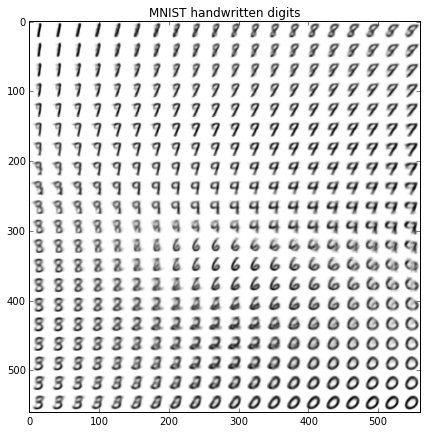

In [10]:
from scipy.stats import norm
from scipy.stats import invgauss
x = np.linspace(0.1,0.9, 20)
v = norm.ppf(x)
z = np.zeros((20**2, 2))
i = 0
for a in v:
    for b in v:
        z[i,0] = a
        z[i,1] = b
        i += 1
z = z.astype('float32')     


samples = model.draw_sample(z).eval()

idx = 0
canvas = np.zeros((28*20, 20*28))
for i in range(20):
    for j in range(20):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = samples[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(7, 7))
plt.imshow(canvas, cmap=plt.cm.binary)
plt.title('MNIST handwritten digits')
plt.show()